# Ordered wire routing

In [90]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# precision in digits used in any rounding operations
ndigits=3
EPS = 1*10**-ndigits

def plot_square(axes, xy, h, w):
    axes.add_patch( patches.Rectangle(xy, w,h))
    
def plot_lines(axes, list_of_pos, prop='r-o'):
    x_values, y_values = [], []
    for pos in list_of_pos:
        x_values += [pos[0]]
        y_values += [pos[1]]
        axes.plot(x_values, y_values, prop)

def create_plot():
    figure = plt.figure()
    plot = figure.add_subplot(111, aspect='equal')
    plot.grid(True)
    return plot

class Block():
    def __init__(self, x, y, h, w, term_xy):
        self.x, self.y = x, y
        self.h, self.w = h, w
        self.term_xy = term_xy
    @property
    def xy(self):
        return (self.x, self.y)
    
    def draw(self, axes):
        axes.add_patch( patches.Rectangle(self.xy, self.w, self.h))
        for xy in self.term_xy:
            axes.plot(xy[0], xy[1], 'og')    
            
class Wire():
    def __init__(self, *corners):
        self._corners = corners
        
    def draw(self, axes):
        x_values, y_values = [], []
        for pos in self._corners:
            x_values += [pos[0]]
            y_values += [pos[1]]
            axes.plot(x_values, y_values, 'r-o')

class Diagram():
    def __init__(self):
        self._blocks = []
        self._wires = []
        
    def add_blocks(self, *blocks):
        self._blocks.extend(blocks)
        
    def add_wires(self, *wires):
        self._wires.extend(wires)
        
    def draw(self, axes):
        for block in self._blocks:
            block.draw(axes)
        for wire in self._wires:
            wire.draw(axes)

def plot_block(axes, block):
    axes.add_patch( patches.Rectangle(block.xy, block.w, block.h))
    for xy in block.term_xy:
        axes.plot(xy[0], xy[1], 'og')

# The idea

Imagine a diagram with several existing wires.

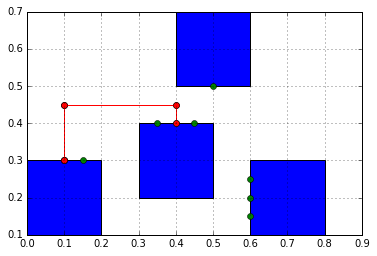

In [91]:
block1 = Block(x=0.0, y=0.1, h=0.2, w=0.2, term_xy=[(0.1, 0.30), (0.15, 0.30)])
block2 = Block(x=0.6, y=0.1, h=0.2, w=0.2, term_xy=[(0.6, 0.2), (0.6, 0.15), (0.6, 0.25)])
block3 = Block(x=0.3, y=0.2, h=0.2, w=0.2, term_xy=[(0.4, 0.4), (0.35, 0.4), (0.45, 0.4)])
block4 = Block(x=0.4, y=0.5, h=0.2, w=0.2, term_xy=[(0.5, 0.5)])

wire1 = Wire((0.1, 0.30), (0.1, 0.45), (0.4, 0.45), (0.4, 0.4))

plot = create_plot()

diagram = Diagram()
diagram.add_blocks(block1, block2, block3, block4)
diagram.add_wires(wire1)
diagram.draw(plot)


Now draw imaginary lines through each wire segment, dividing up the diagram into rectangular areas.

The idea of order-based wire routing is that as long as a wire has a corner in one of these rectangles, it doesn't matter where exactly in this rectangle the corner is. It only matters if the corner is in this rectangle or in a different one.

The advantage of this over a fixed grid is that maximum freedom in routing is provided (no space can be so narrow that this algorithm cannot find a route through it) while at the same time no two routes evaluated in the shortest path algorithm actually end up being equivalent.

# Simplified algorithm overview

* Split the diagram up into rectangles
* Create a graph connecting the centers of all rectangles
* Run the shortest path algorithm on this graph
* Once given the shortest logical path, determine the physical path

## Split the diagram up into rectangles

Take the x-coordinate of each vertical wire segment in the diagram and sort them. Do the same for the y-coordinates of the horizontal wire segments. These lists of x and y coordinates represent a subdivision of the total diagram into rectangles.

[[Rect(l=-0.080000, r=0.000000, t=0.040000, b=0.100000), Rect(l=-0.080000, r=0.000000, t=0.100000, b=0.200000), Rect(l=-0.080000, r=0.000000, t=0.200000, b=0.300000), Rect(l=-0.080000, r=0.000000, t=0.300000, b=0.300000), Rect(l=-0.080000, r=0.000000, t=0.300000, b=0.400000), Rect(l=-0.080000, r=0.000000, t=0.400000, b=0.450000), Rect(l=-0.080000, r=0.000000, t=0.450000, b=0.500000), Rect(l=-0.080000, r=0.000000, t=0.500000, b=0.700000), Rect(l=-0.080000, r=0.000000, t=0.700000, b=0.760000)], [Rect(l=0.000000, r=0.100000, t=0.040000, b=0.100000), Rect(l=0.000000, r=0.100000, t=0.100000, b=0.200000), Rect(l=0.000000, r=0.100000, t=0.200000, b=0.300000), Rect(l=0.000000, r=0.100000, t=0.300000, b=0.300000), Rect(l=0.000000, r=0.100000, t=0.300000, b=0.400000), Rect(l=0.000000, r=0.100000, t=0.400000, b=0.450000), Rect(l=0.000000, r=0.100000, t=0.450000, b=0.500000), Rect(l=0.000000, r=0.100000, t=0.500000, b=0.700000), Rect(l=0.000000, r=0.100000, t=0.700000, b=0.760000)], [Rect(l=0.1000

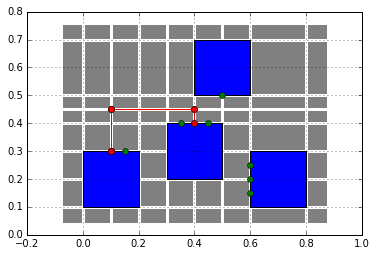

In [92]:
class Rectangle():
    def __init__(self, left, right, top, bottom):
        self.left = left
        self.right = right
        self.top = top
        self.bottom = bottom
        
    def __repr__(self):
        return "Rect(l=%f, r=%f, t=%f, b=%f)" % (self.left, self.right, self.top, self.bottom)

def diagram_to_rectangles(diagram):
    x_coords = set()
    y_coords = set()
    
    for block in diagram._blocks:
        x_coords.add(block.x)
        x_coords.add(block.x + block.w)
        y_coords.add(block.y)
        y_coords.add(block.y + block.h)
    
    for wire in diagram._wires:
        for corner in wire._corners:
            x_coords.add(corner[0])
            y_coords.add(corner[1])
            
    xmargin = (max(x_coords) - min(x_coords)) / 10.0
    ymargin = (max(y_coords) - min(y_coords)) / 10.0
    min_x = min(x_coords) - xmargin
    max_x = max(x_coords) + xmargin
    min_y = min(y_coords) - ymargin
    max_y = max(y_coords) + ymargin
    x_coords = [min_x] + sorted(x_coords) + [max_x]
    y_coords = [min_y] + sorted(y_coords) + [max_y]

    rects = []
    for l, r in zip(x_coords[:-1], x_coords[1:]):
        rects.append([])
        for t, b in zip(y_coords[:-1], y_coords[1:]):
            rects[-1].append(Rectangle(l, r, t, b))
            
    return rects

rects = diagram_to_rectangles(diagram)
print(rects)

plot = create_plot()
#plot.axis('off')
for rectrow in rects:
    for r in rectrow:
        plot.add_patch(patches.Rectangle( (r.left, r.top), (r.right - r.left), (r.bottom - r.top),
                                          facecolor = '0.5', linewidth = 3, edgecolor = 'w'))
diagram.draw(plot)


## Create a graph

A graph needs to be created for shortest path calculation. Because we intend to create higher cost for creating corners, we need to encode what rectangle we came from in this graph. We can do this by creating two nodes for each rectangle. One to indicate that the last step was a horizontal one, the other to indicate that it was vertical. 
The "horizontal" nodes in a row of rectangles must be connected by low-cost edges. Similarly the "vertical" nodes in a column of rectangles must be connected by low-cost edges. Now to make corners possible, each "vertical" node must be connected to the "horizontal" nodes on either side of it through a high-cost edge. Similarly each "horizontal" node must be connected to the "vertical" nodes directly above and below it through a high-cost edge.

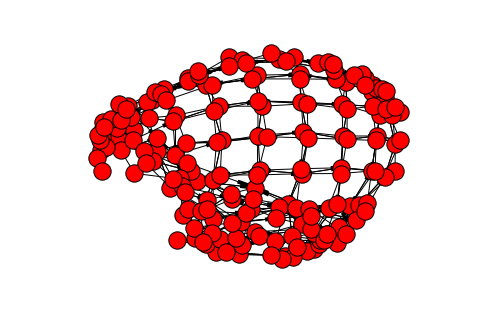

In [93]:
%matplotlib inline
import copy
import networkx as nx

graph = nx.DiGraph()

horiz_rects = rects
vert_rects = copy.deepcopy(rects)

width = len(rects)
height = len(rects[0])

cheap = 1.0
expensive = cheap * 5

for x in range(width):
    for y in range(height):
        if x > 0:
            graph.add_edge(horiz_rects[x][y], horiz_rects[x - 1][y], weight = cheap)
            graph.add_edge(vert_rects[x][y], horiz_rects[x - 1][y], weight = expensive)
        if x < width - 1:
            graph.add_edge(horiz_rects[x][y], horiz_rects[x + 1][y], weight = cheap)
            graph.add_edge(vert_rects[x][y], horiz_rects[x + 1][y], weight = expensive)
        if y > 0:
            graph.add_edge(vert_rects[x][y], vert_rects[x][y - 1], weight = cheap)
            graph.add_edge(horiz_rects[x][y], vert_rects[x][y - 1], weight = expensive)
        if y < height - 1:
            graph.add_edge(vert_rects[x][y], vert_rects[x][y + 1], weight = cheap)
            graph.add_edge(horiz_rects[x][y], vert_rects[x][y + 1], weight = expensive)

nx.draw_spring(graph)

Edges crossing an actual wire segment should also be more costly than edges crossing the imaginary line extended from a wire segment.

## Run shortest path

Run the shortest path algorithm on the graph


In [94]:
start = vert_rects[2][2]
end = horiz_rects[7][2]

shortest_path = nx.dijkstra_path(graph, start, end)

print(shortest_path)


[Rect(l=0.100000, r=0.200000, t=0.200000, b=0.300000), Rect(l=0.200000, r=0.300000, t=0.200000, b=0.300000), Rect(l=0.300000, r=0.400000, t=0.200000, b=0.300000), Rect(l=0.400000, r=0.500000, t=0.200000, b=0.300000), Rect(l=0.500000, r=0.600000, t=0.200000, b=0.300000), Rect(l=0.600000, r=0.600000, t=0.200000, b=0.300000)]


## Turn logical path into physical path

Now that you have the logical path that tells you how a wire is routed between other wires, you can get the actual position of each wire segment by averaging the x-coordinates of the wires to its left and right for a vertical wire segment and averaging the y-coordinates of the wires above and below it for a horizontal wire segment.

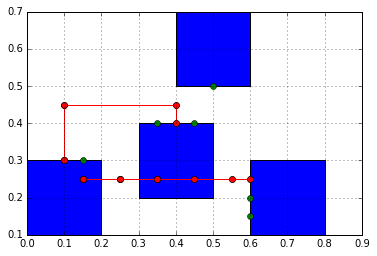

In [95]:
new_wire = Wire(*[ ((r.left + r.right) / 2, (r.top + r.bottom) / 2) for r in shortest_path])

new_diagram = copy.deepcopy(diagram)
new_diagram.add_wires(new_wire)

plot = create_plot()
new_diagram.draw(plot)

# Removing oversimplifications

## Avoiding evaluation of multiple equivalent paths

A result of creating an undirected graph, is that a high-cost edge from a "vertical" node to the "horizontal" node next to it can also be navigated in the other direction from the "horizontal" node to the "vertical node". Conceptually that is incorrect, because travelling horizontally from a "horizontal" node should be cheap. Luckily the only effect of this is that the chosen path will be either more expensive than another equivalent path (when continuing to travel horizontally after the "vertical" node) or equally expensive (when travelling vertically after reaching the "vertical" node).

If for performance reasons the number of possible paths are to be kept to a minimum, then a directed graph should be used instead. Each low-cost edge should be turned into two arrows, one in each direction. Each high-cost edge should be turned into an arrow towards the "vertical" node if the edge was vertical and towards the horizontal node if the edge was horizontal.

## Avoiding routing through components

To avoid routing through components two things have to be done.

1. The outer edges of components should be considered line segments when splitting up the diagram into rectangles
2. We should not create a node for any rectangles inside a component, but...
3. For each of the two components that are connected by the wire to be routed, the rectangle inside the component and adjacent to the connector should get one node in the graph. The type (horizontal or vertical) of that node should match the orientation of the connector.

## Avoiding routing in places where there is not enough space

Because the shortest path algorithm calculates a logical route, it will always assume that there is space to route a wire in between other wires or components. The graph must be preprocessed to remove nodes that are between wire segments that are too close to each other.

Note that:

1. wire segments with more one rectangle between them, may still be too close to each other to route between
2. wire segments may be very close to each other in one dimension, but if they are far enough apart on in the other dimension (x) routing may still happen in the space between. Only remove nodes between both wire segments.

## Allowing routes around objects already on the diagram

In order to allow routes around the edge of the diagram when there are too many wires in the center, add the edges to the list of x and y coordinates as well (make sure that these coordinates are beyond any existing objects).